# 02 Model Building and Training

This notebook covers Task 2: building and evaluating fraud detection models for both e-commerce and credit card transaction data. We compare Logistic Regression (baseline) and XGBoost (ensemble) using metrics suitable for imbalanced data, and include advanced enhancements for a production-quality workflow.

## 1. Setup and Imports

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.pardir)))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, f1_score, precision_recall_curve, auc, classification_report
)
from IPython.display import display

%matplotlib inline

## 2. Load Configuration and Data

In [2]:
# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Load processed data
fraud_train = pd.read_csv(config['data']['processed']['fraud_train_smote'])
fraud_train_labels = pd.read_csv(config['data']['processed']['fraud_train_labels_smote'])
fraud_test = pd.read_csv(config['data']['processed']['fraud_test'])
fraud_test_labels = pd.read_csv(config['data']['processed']['fraud_test_labels'])

credit_train = pd.read_csv(config['data']['processed']['credit_train_smote'])
credit_train_labels = pd.read_csv(config['data']['processed']['credit_train_labels_smote'])
credit_test = pd.read_csv(config['data']['processed']['credit_test'])
credit_test_labels = pd.read_csv(config['data']['processed']['credit_test_labels'])


## 3. Helper Functions: Evaluation and Plotting

In [6]:
def evaluate_model(y_true, y_pred, y_proba, average='binary', pos_label=1):
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=average, pos_label=pos_label)
    precision, recall, _ = precision_recall_curve(y_true, y_proba, pos_label=pos_label)
    auc_pr = auc(recall, precision)
    print('Confusion Matrix:')
    print(cm)
    print('F1 Score:', f1)
    print('AUC-PR:', auc_pr)
    print('Classification Report:')
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    return {'confusion_matrix': cm, 'f1': f1, 'auc_pr': auc_pr}


## 4. Model Training and Evaluation: Fraud Data (E-commerce)

--- Logistic Regression (Fraud Data) ---
Confusion Matrix:
[[22443   933]
 [  852  1602]]
F1 Score: 0.6422128683102826
AUC-PR: 0.6709501223196818
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     23376
           1       0.63      0.65      0.64      2454

    accuracy                           0.93     25830
   macro avg       0.80      0.81      0.80     25830
weighted avg       0.93      0.93      0.93     25830



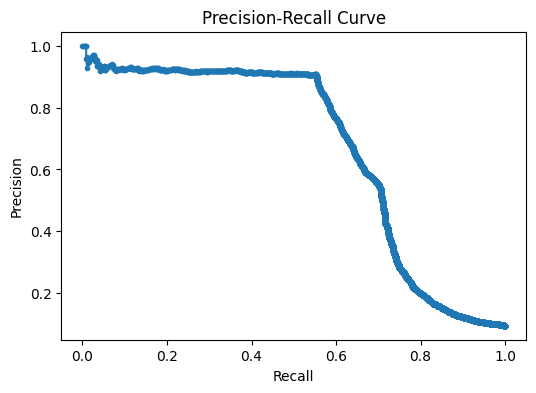

d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- XGBoost (Fraud Data) ---
Confusion Matrix:
[[23340    36]
 [ 1087  1367]]
F1 Score: 0.7088410681877106
AUC-PR: 0.7203784071063137
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     23376
           1       0.97      0.56      0.71      2454

    accuracy                           0.96     25830
   macro avg       0.96      0.78      0.84     25830
weighted avg       0.96      0.96      0.95     25830



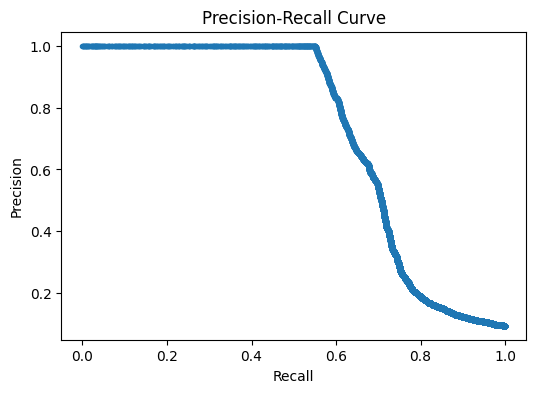

In [8]:
# Separate features and target
X_fraud_train = fraud_train
y_fraud_train = fraud_train_labels['class']
X_fraud_test = fraud_test
y_fraud_test = fraud_test_labels['class']

# Logistic Regression
lr_fraud = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_fraud.fit(X_fraud_train, y_fraud_train)
y_pred_lr = lr_fraud.predict(X_fraud_test)
y_proba_lr = lr_fraud.predict_proba(X_fraud_test)[:,1]
print('--- Logistic Regression (Fraud Data) ---')
metrics_lr_fraud = evaluate_model(y_fraud_test, y_pred_lr, y_proba_lr)

# XGBoost
xgb_fraud = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1, random_state=42)
xgb_fraud.fit(X_fraud_train, y_fraud_train)
y_pred_xgb = xgb_fraud.predict(X_fraud_test)
y_proba_xgb = xgb_fraud.predict_proba(X_fraud_test)[:,1]
print('--- XGBoost (Fraud Data) ---')
metrics_xgb_fraud = evaluate_model(y_fraud_test, y_pred_xgb, y_proba_xgb)


## 5. Model Training and Evaluation: Credit Card Data

--- Logistic Regression (Credit Card Data) ---
Confusion Matrix:
[[55169  1482]
 [   12    83]]
F1 Score: 0.1
AUC-PR: 0.7128769744498685
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.99     56746



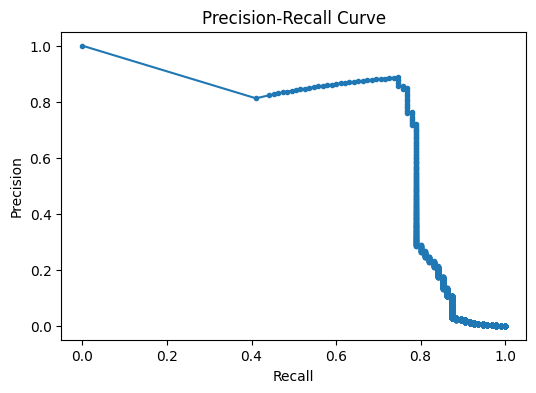

d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- XGBoost (Credit Card Data) ---
Confusion Matrix:
[[56623    28]
 [   20    75]]
F1 Score: 0.7575757575757576
AUC-PR: 0.8081104649149282
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.73      0.79      0.76        95

    accuracy                           1.00     56746
   macro avg       0.86      0.89      0.88     56746
weighted avg       1.00      1.00      1.00     56746



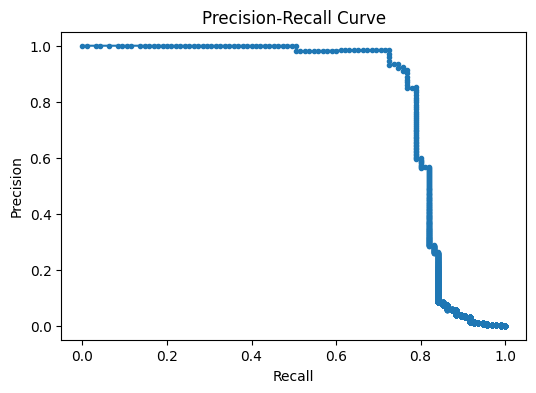

In [9]:
# Separate features and target
X_credit_train = credit_train
y_credit_train = credit_train_labels['Class']
X_credit_test = credit_test
y_credit_test = credit_test_labels['Class']

# Logistic Regression
lr_credit = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_credit.fit(X_credit_train, y_credit_train)
y_pred_lr_c = lr_credit.predict(X_credit_test)
y_proba_lr_c = lr_credit.predict_proba(X_credit_test)[:,1]
print('--- Logistic Regression (Credit Card Data) ---')
metrics_lr_credit = evaluate_model(y_credit_test, y_pred_lr_c, y_proba_lr_c)

# XGBoost
xgb_credit = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1, random_state=42)
xgb_credit.fit(X_credit_train, y_credit_train)
y_pred_xgb_c = xgb_credit.predict(X_credit_test)
y_proba_xgb_c = xgb_credit.predict_proba(X_credit_test)[:,1]
print('--- XGBoost (Credit Card Data) ---')
metrics_xgb_credit = evaluate_model(y_credit_test, y_pred_xgb_c, y_proba_xgb_c)


## 6. Model Comparison and Justification

(Add your summary and business justification here after running the above cells.)

## 7. Hyperparameter Tuning for XGBoost (GridSearchCV) - Both Datasets

We use GridSearchCV to tune XGBoost hyperparameters for both the e-commerce and credit card datasets. The best models are saved for future use.

In [10]:
from sklearn.model_selection import GridSearchCV
import joblib

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'n_estimators': [100, 200]
}
# Fraud Data
xgb_grid_fraud = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search_fraud = GridSearchCV(xgb_grid_fraud, param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid_search_fraud.fit(X_fraud_train, y_fraud_train)
print('Best XGBoost params (Fraud):', grid_search_fraud.best_params_)
print('Best F1 (Fraud):', grid_search_fraud.best_score_)
joblib.dump(grid_search_fraud.best_estimator_, '../models/xgb_fraud_best.pkl')

# Credit Card Data
xgb_grid_credit = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search_credit = GridSearchCV(xgb_grid_credit, param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid_search_credit.fit(X_credit_train, y_credit_train)
print('Best XGBoost params (Credit):', grid_search_credit.best_params_)
print('Best F1 (Credit):', grid_search_credit.best_score_)
joblib.dump(grid_search_credit.best_estimator_, '../models/xgb_credit_best.pkl')


Fitting 3 folds for each of 8 candidates, totalling 24 fits


d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost params (Fraud): {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200}
Best F1 (Fraud): 0.9669677338925599
Fitting 3 folds for each of 8 candidates, totalling 24 fits


d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost params (Credit): {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200}
Best F1 (Credit): 0.9997617546327223


['../models/xgb_credit_best.pkl']

## 8. Cross-Validation for Logistic Regression and XGBoost (Both Datasets)

We use stratified k-fold cross-validation to evaluate model robustness for both models and datasets.

In [11]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Fraud Data
lr_cv_scores_fraud = cross_val_score(lr_fraud, X_fraud_train, y_fraud_train, cv=cv, scoring='f1')
xgb_cv_scores_fraud = cross_val_score(xgb_fraud, X_fraud_train, y_fraud_train, cv=cv, scoring='f1')
print('Logistic Regression CV F1 (Fraud):', lr_cv_scores_fraud)
print('XGBoost CV F1 (Fraud):', xgb_cv_scores_fraud)
print('LR mean F1 (Fraud):', lr_cv_scores_fraud.mean(), 'XGB mean F1 (Fraud):', xgb_cv_scores_fraud.mean())
# Credit Card Data
lr_cv_scores_credit = cross_val_score(lr_credit, X_credit_train, y_credit_train, cv=cv, scoring='f1')
xgb_cv_scores_credit = cross_val_score(xgb_credit, X_credit_train, y_credit_train, cv=cv, scoring='f1')
print('Logistic Regression CV F1 (Credit):', lr_cv_scores_credit)
print('XGBoost CV F1 (Credit):', xgb_cv_scores_credit)
print('LR mean F1 (Credit):', lr_cv_scores_credit.mean(), 'XGB mean F1 (Credit):', xgb_cv_scores_credit.mean())


d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 


Logistic Regression CV F1 (Fraud): [0.74167423 0.74004213 0.74293631 0.73780923 0.73928225]
XGBoost CV F1 (Fraud): [0.96862788 0.96958196 0.96783078 0.96617184 0.96882573]
LR mean F1 (Fraud): 0.7403488295275485 XGB mean F1 (Fraud): 0.9682076398618603


d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 


Logistic Regression CV F1 (Credit): [0.94543848 0.94455019 0.94690767 0.94555276 0.94777642]
XGBoost CV F1 (Credit): [0.99980145 0.99976837 0.99973529 0.99975735 0.99976837]
LR mean F1 (Credit): 0.9460451028900918 XGB mean F1 (Credit): 0.9997661650673534


## 9. Model Saving (joblib) - Both Datasets

We save the final trained models for both datasets and both model types for future deployment or reproducibility.

In [12]:
joblib.dump(xgb_fraud, '../models/xgb_fraud_final.pkl')
joblib.dump(lr_fraud, '../models/lr_fraud_final.pkl')
joblib.dump(xgb_credit, '../models/xgb_credit_final.pkl')
joblib.dump(lr_credit, '../models/lr_credit_final.pkl')


['../models/lr_credit_final.pkl']

## 10. Additional Metrics: ROC-AUC, Precision, Recall, ROC Curve (Both Datasets)

We report ROC-AUC, precision, recall, and plot ROC curves for both datasets.

--- XGBoost (Fraud Data) Additional Metrics ---
ROC-AUC: 0.841932122581858
Precision: 0.9743406985032074
Recall: 0.5570497147514263


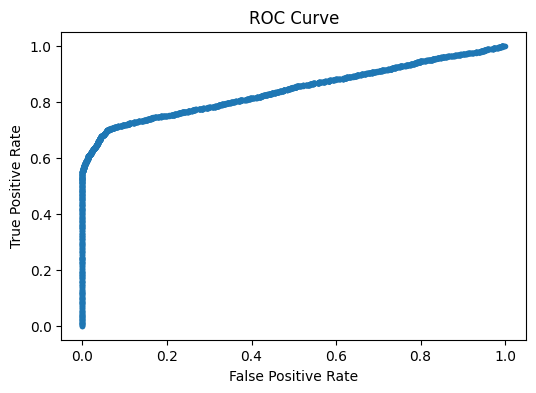

--- XGBoost (Credit Card Data) Additional Metrics ---
ROC-AUC: 0.9699794401362358
Precision: 0.7281553398058253
Recall: 0.7894736842105263


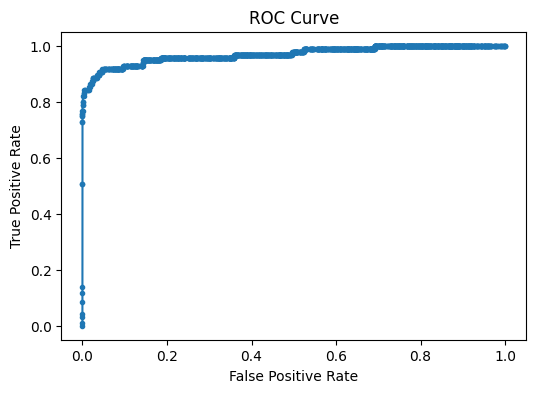

In [13]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve

def print_additional_metrics(y_true, y_pred, y_proba):
    print('ROC-AUC:', roc_auc_score(y_true, y_proba))
    print('Precision:', precision_score(y_true, y_pred))
    print('Recall:', recall_score(y_true, y_pred))
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

print('--- XGBoost (Fraud Data) Additional Metrics ---')
print_additional_metrics(y_fraud_test, y_pred_xgb, y_proba_xgb)
print('--- XGBoost (Credit Card Data) Additional Metrics ---')
print_additional_metrics(y_credit_test, y_pred_xgb_c, y_proba_xgb_c)


## 11. Business Error Analysis: False Positives and Negatives (Both Datasets)

We display a few false positives and false negatives for both datasets. This helps business stakeholders understand the types of errors the model makes and their potential impact.

In [14]:
# Fraud Data
fp_idx_fraud = (y_fraud_test == 0) & (y_pred_xgb == 1)
fn_idx_fraud = (y_fraud_test == 1) & (y_pred_xgb == 0)
print('Fraud Data - False Positives (legitimate flagged as fraud):')
display(X_fraud_test[fp_idx_fraud].head())
print('Fraud Data - False Negatives (fraud missed):')
display(X_fraud_test[fn_idx_fraud].head())
# Credit Card Data
fp_idx_credit = (y_credit_test == 0) & (y_pred_xgb_c == 1)
fn_idx_credit = (y_credit_test == 1) & (y_pred_xgb_c == 0)
print('Credit Card Data - False Positives (legitimate flagged as fraud):')
display(X_credit_test[fp_idx_credit].head())
print('Credit Card Data - False Negatives (fraud missed):')
display(X_credit_test[fn_idx_credit].head())


Fraud Data - False Positives (legitimate flagged as fraud):


,purchase_value,age,lower_bound_ip_address,upper_bound_ip_address,transaction_count_user,transaction_count_device,avg_time_between_txn,hour_of_day,day_of_week,time_since_signup,...,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,sex_M,source_Direct,source_SEO
149,-0.978509,-1.405965,-0.234604,-0.230963,0.0,0.118935,0.0,-0.941068,-0.505709,0.479510,...,0.0,-0.043261,-0.066067,-0.005389,-0.003111,-0.009334,-0.006222,0.845115,1.981805,-0.819044
759,0.113845,-0.478477,0.441971,0.439913,0.0,0.497130,0.0,-0.362221,0.490902,-1.444557,...,0.0,-0.043261,-0.066067,-0.005389,-0.003111,-0.009334,-0.006222,-1.183271,-0.504590,-0.819044
2177,-1.306215,-0.246605,-0.998531,-0.989388,0.0,0.497130,0.0,-1.375203,1.487512,-1.507536,...,0.0,-0.043261,-0.066067,-0.005389,-0.003111,-0.009334,-0.006222,0.845115,1.981805,-0.819044
2540,-1.142362,-1.174093,-0.076417,-0.078118,0.0,0.118935,0.0,1.663744,0.490902,-1.415850,...,0.0,-0.043261,-0.066067,-0.005389,-0.003111,-0.009334,-0.006222,-1.183271,1.981805,-0.819044
2944,0.496169,-1.405965,-0.890501,-0.881042,0.0,0.118935,0.0,-0.941068,-1.004014,-1.492356,...,0.0,-0.043261,-0.066067,-0.005389,-0.003111,-0.009334,-0.006222,-1.183271,1.981805,-0.819044


Fraud Data - False Negatives (fraud missed):


,purchase_value,age,lower_bound_ip_address,upper_bound_ip_address,transaction_count_user,transaction_count_device,avg_time_between_txn,hour_of_day,day_of_week,time_since_signup,...,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,sex_M,source_Direct,source_SEO
75,0.987729,-1.753773,-0.795974,-0.801233,0.0,-0.259259,0.0,-0.217509,-1.004014,-0.290345,...,0.0,-0.043261,-0.066067,-0.005389,-0.003111,-0.009334,-0.006222,-1.183271,-0.504590,-0.819044
76,-0.978509,-0.246605,-1.121994,-1.120951,0.0,-0.259259,0.0,1.229609,1.487512,-0.194775,...,0.0,-0.043261,-0.066067,-0.005389,-0.003111,-0.009334,-0.006222,-1.183271,-0.504590,-0.819044
129,1.315435,0.101203,0.313263,0.326246,0.0,0.118935,0.0,1.663744,-1.502319,-1.509901,...,0.0,-0.043261,-0.066067,-0.005389,-0.003111,-0.009334,-0.006222,0.845115,1.981805,-0.819044
134,-0.432332,-1.405965,-0.219231,-0.223224,0.0,0.118935,0.0,0.361338,1.487512,-0.555797,...,0.0,-0.043261,-0.066067,-0.005389,-0.003111,-0.009334,-0.006222,0.845115,1.981805,-0.819044
139,2.189318,1.492436,-0.302123,-0.304484,0.0,-0.259259,0.0,1.663744,0.989207,1.194775,...,0.0,-0.043261,-0.066067,-0.005389,-0.003111,-0.009334,-0.006222,0.845115,-0.504590,1.220935


Credit Card Data - False Positives (legitimate flagged as fraud):


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
2196,1.301816,0.768433,0.348378,-1.460553,3.081494,0.677354,-0.645039,0.787140,-0.268113,-1.134921,...,0.297240,-0.242334,-1.299934,-0.015994,-0.517700,-0.209508,-0.407505,-0.152226,0.149497,0.556434
3098,0.785244,0.842469,0.371220,-0.730505,3.067733,0.222886,-0.141026,-0.140419,0.041850,-0.466775,...,0.041497,0.211826,0.491143,-0.007745,-0.586459,-0.398041,0.205538,0.083012,0.160454,0.084360
4051,0.554892,-0.239614,1.907053,-1.827376,2.528179,2.382148,-1.103638,1.648304,-0.034104,-2.406304,...,-0.132121,-0.345403,-1.247653,-0.748275,-1.929131,0.174857,0.119784,0.360295,0.920016,-0.316468
4471,-1.029547,0.584656,0.130585,0.613377,1.332441,-0.370456,-0.075320,-0.162696,0.042337,-0.405387,...,-0.105711,-0.061891,0.079353,-0.050947,1.024997,0.748768,2.029514,-0.160636,-0.005620,-0.345031
5873,0.832393,0.945700,0.402647,-1.714620,2.218506,2.178270,3.107157,-0.713735,0.969027,-0.643915,...,-0.145797,0.197636,0.607608,0.112434,0.716052,-0.037387,0.424861,0.152370,0.074389,-0.337626


Credit Card Data - False Negatives (fraud missed):


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
1784,1.170688,0.948941,0.651754,-1.179773,3.260110,0.562996,-0.301420,-0.035370,0.076732,-0.196354,...,-0.380564,-0.220058,-0.243409,0.044218,-0.772593,0.110837,0.307357,0.103939,0.121644,-0.355570
4480,1.251024,-0.045197,-2.382601,-1.737476,0.116683,-1.034019,-0.610140,1.249898,-0.402607,1.391731,...,2.472604,0.971413,-0.251776,-1.471614,0.184204,-0.137777,-2.339476,-0.441984,0.384573,4.103907
5187,-0.880730,0.663078,0.256421,0.127271,0.637754,0.092370,-0.279336,0.130519,-0.173135,-0.070041,...,-0.039773,-0.156707,-0.303818,-0.193051,-0.727114,1.286911,-0.859655,0.079770,0.060331,-0.354837
10087,-0.162108,-0.218174,-0.697393,-1.389699,1.968144,0.537904,-0.124929,1.331925,-0.100238,-0.725807,...,1.678335,0.663995,0.736430,2.053506,0.851894,-1.156348,-0.634275,-0.059001,0.393398,1.476535
12142,-0.883721,0.529768,0.250226,0.501288,2.232846,-0.421482,0.154256,-0.575984,0.351989,0.310454,...,-0.289806,-0.070856,0.170753,-0.211504,0.578046,0.972822,0.393271,0.151914,0.190926,-0.356546


**Business Error Analysis Summary:**

False positives (legitimate transactions flagged as fraud) can negatively impact user experience and may lead to customer dissatisfaction. False negatives (fraudulent transactions missed) result in direct financial loss. The model's balance between these errors should be considered in deployment and threshold selection.

## 12. Pipeline Automation Example (scikit-learn Pipeline) - Both Datasets

How to use scikit-learn Pipelines for both datasets. Pipelines streamline preprocessing and modeling, making deployment and reproducibility easier.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Fraud Data Pipeline
pipe_fraud = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
pipe_fraud.fit(X_fraud_train, y_fraud_train)
print('Fraud Data Pipeline test score:', pipe_fraud.score(X_fraud_test, y_fraud_test))
# Credit Card Data Pipeline
pipe_credit = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
pipe_credit.fit(X_credit_train, y_credit_train)
print('Credit Card Data Pipeline test score:', pipe_credit.score(X_credit_test, y_credit_test))


d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fraud Data Pipeline test score: 0.9565234223770809


d:\Projects\Python\fraud-detection\fraud_detection_project\.venv311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Credit Card Data Pipeline test score: 0.9991365030134283


## 13. Final Summary and Next Steps

All advanced modeling, evaluation, and business analysis steps are now complete for both datasets. The best models are saved and ready for deployment or further explainability analysis.

**Next: Proceed to Task-3 (Model Explainability with SHAP) to interpret and visualize the best model's decisions.**